<a href="https://colab.research.google.com/github/realfolkcode/LabelPropagation/blob/master/label_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Install

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import r2_score
import scipy
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install gpytorch

     |████████████████████████████████| 310 kB 4.4 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=14f9bfd0544c1f30e3c88bb0d229f039c1fb9b7d45fae9608cdf76d57422ec0f
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


In [3]:
from gpytorch.utils import linear_cg

In [4]:
!git clone https://github.com/realfolkcode/LabelPropagation.git

Cloning into 'LabelPropagation'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 146 (delta 57), reused 90 (delta 25), pack-reused 0
Receiving objects: 100% (146/146), 409.13 KiB | 717.00 KiB/s, done.
Resolving deltas: 100% (57/57), done.


In [7]:
from LabelPropagation.utils import load_jj_data, set_random_seeds

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 0

# Process Data

In [9]:
path = "LabelPropagation/data/county/election/2012"
adj, X, y, idx_train, idx_val, idx_test = load_jj_data(path)
idx_train_val = torch.cat((idx_train, idx_val))
y = y.reshape(-1, 1)

print("adj:", adj.shape)
print("features:", X.shape)
print("labels:", y.shape)
print("idx_train:", idx_train.shape)
print("idx_val:", idx_val.shape)
print("idx_test:", idx_test.shape)

adj: torch.Size([3234, 3234])
features: torch.Size([3234, 6])
labels: torch.Size([3234, 1])
idx_train: torch.Size([1941])
idx_val: torch.Size([646])
idx_test: torch.Size([647])


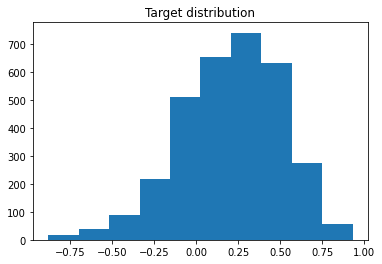

In [10]:
plt.hist(y.flatten())
plt.title('Target distribution')
plt.show()

# MLP

In [11]:
class MLP(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(n_in, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
        )
        self.regressor = nn.Linear(16, 1)
    
    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

In [12]:
def epoch_train(model, loader, criterion, opt):
    train_loss = 0
    model.train()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
    train_loss /= len(loader)
    return train_loss

In [13]:
def epoch_val(model, loader, criterion):
    val_loss = 0
    target_lst = []
    output_lst = []
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            target_lst += target.tolist()
            output_lst += output.tolist()
            val_loss = criterion(output, target).item()
    r2 = r2_score(target_lst, output_lst)
    val_loss /= len(loader)
    return val_loss, r2

In [14]:
set_random_seeds(seed_value=RANDOM_SEED, device=device)

mlp = MLP(6).to(device)

In [15]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(mlp.parameters())

In [16]:
batch_size = 128

train_loader = DataLoader(TensorDataset(X[idx_train], y[idx_train]), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X[idx_val], y[idx_val]), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X[idx_test], y[idx_test]), batch_size=batch_size, shuffle=False)

In [17]:
num_epochs = 75

train_loss = []
val_loss = []
val_r2 = []
test_loss = []
test_r2 = []

best_r2 = 0
best_epoch = 0

for i in tqdm(range(num_epochs)):
    loss = epoch_train(mlp, train_loader, criterion, opt)
    train_loss.append(np.sqrt(loss))

    loss, r2 = epoch_val(mlp, val_loader, criterion)
    val_loss.append(np.sqrt(loss))
    val_r2.append(r2)
    if r2 > best_r2:
        best_epoch = i
        best_r2 = r2


    loss, r2 = epoch_val(mlp, test_loader, criterion)
    test_loss.append(np.sqrt(loss))
    test_r2.append(r2)
    print('---------------------------------------------------------')
    print(f'Epoch: {i}, Val R2: {val_r2[-1]}, Test R2: {test_r2[-1]}')

  4%|▍         | 3/75 [00:00<00:06, 11.14it/s]

---------------------------------------------------------
Epoch: 0, Val R2: -0.002688273280749609, Test R2: 0.04538794373042765
---------------------------------------------------------
Epoch: 1, Val R2: 0.0944001767221817, Test R2: 0.14554112564865662
---------------------------------------------------------
Epoch: 2, Val R2: 0.15563058335039515, Test R2: 0.20056630361667838


  8%|▊         | 6/75 [00:00<00:04, 16.49it/s]

---------------------------------------------------------
Epoch: 3, Val R2: 0.20069958464503046, Test R2: 0.2413663259263672
---------------------------------------------------------
Epoch: 4, Val R2: 0.2291284316039175, Test R2: 0.2625314191006044
---------------------------------------------------------
Epoch: 5, Val R2: 0.25388043653035475, Test R2: 0.2794290877950212
---------------------------------------------------------
Epoch: 6, Val R2: 0.2676683783207986, Test R2: 0.29030533820540627
---------------------------------------------------------
Epoch: 7, Val R2: 0.2813743772020848, Test R2: 0.29466272374889946


 16%|█▌        | 12/75 [00:00<00:02, 21.16it/s]

---------------------------------------------------------
Epoch: 8, Val R2: 0.2887310883528038, Test R2: 0.298929047478675
---------------------------------------------------------
Epoch: 9, Val R2: 0.29379257458979535, Test R2: 0.3023981125278895
---------------------------------------------------------
Epoch: 10, Val R2: 0.2977063319919474, Test R2: 0.30371856661070984
---------------------------------------------------------
Epoch: 11, Val R2: 0.3019018183700899, Test R2: 0.3070781842416127
---------------------------------------------------------
Epoch: 12, Val R2: 0.31265005559263015, Test R2: 0.3160453918443673
---------------------------------------------------------

 24%|██▍       | 18/75 [00:00<00:02, 23.85it/s]


Epoch: 13, Val R2: 0.312584709004624, Test R2: 0.31299526468603
---------------------------------------------------------
Epoch: 14, Val R2: 0.31851204982963055, Test R2: 0.32204549907720237
---------------------------------------------------------
Epoch: 15, Val R2: 0.32302061833031015, Test R2: 0.3272451565718759
---------------------------------------------------------
Epoch: 16, Val R2: 0.32491927943771737, Test R2: 0.3282551993468482
---------------------------------------------------------
Epoch: 17, Val R2: 0.3277357470810227, Test R2: 0.3303355958154186
---------------------------------------------------------
Epoch: 18, Val R2: 0.3309782361096779, Test R2: 0.3310277255846166


 32%|███▏      | 24/75 [00:01<00:02, 24.81it/s]

---------------------------------------------------------
Epoch: 19, Val R2: 0.3366804902897278, Test R2: 0.33683946698428935
---------------------------------------------------------
Epoch: 20, Val R2: 0.33678527618770926, Test R2: 0.33149987688850024
---------------------------------------------------------
Epoch: 21, Val R2: 0.33990876548562554, Test R2: 0.3369607476528025
---------------------------------------------------------
Epoch: 22, Val R2: 0.34500300154693186, Test R2: 0.34487680132967136
---------------------------------------------------------
Epoch: 23, Val R2: 0.34472023309896793, Test R2: 0.34248518645100456
---------------------------------------------------------
Epoch: 24, Val R2: 0.3510103439075518, Test R2: 0.3477777369365881


 40%|████      | 30/75 [00:01<00:01, 24.05it/s]

---------------------------------------------------------
Epoch: 25, Val R2: 0.3517254553083625, Test R2: 0.3487965517267887
---------------------------------------------------------
Epoch: 26, Val R2: 0.3510262227267451, Test R2: 0.34785998179127
---------------------------------------------------------
Epoch: 27, Val R2: 0.35367838862108536, Test R2: 0.3519651569987068
---------------------------------------------------------
Epoch: 28, Val R2: 0.357053938171601, Test R2: 0.3555611088938091
---------------------------------------------------------
Epoch: 29, Val R2: 0.3572595724769675, Test R2: 0.3577333161396178


 48%|████▊     | 36/75 [00:01<00:01, 24.17it/s]

---------------------------------------------------------
Epoch: 30, Val R2: 0.3595321842304384, Test R2: 0.3591631736505779
---------------------------------------------------------
Epoch: 31, Val R2: 0.3613820540165008, Test R2: 0.3590167798862187
---------------------------------------------------------
Epoch: 32, Val R2: 0.36220288030157277, Test R2: 0.36089114192309835
---------------------------------------------------------
Epoch: 33, Val R2: 0.3646436472983745, Test R2: 0.36788060624839003
---------------------------------------------------------
Epoch: 34, Val R2: 0.36302426333647797, Test R2: 0.35910805329508255
---------------------------------------------------------
Epoch: 35, Val R2: 0.36638321671714635, Test R2: 0.3646927905732712


 56%|█████▌    | 42/75 [00:01<00:01, 24.50it/s]

---------------------------------------------------------
Epoch: 36, Val R2: 0.3671627540223559, Test R2: 0.3646665017055467
---------------------------------------------------------
Epoch: 37, Val R2: 0.3669742013923788, Test R2: 0.36486100966590396
---------------------------------------------------------
Epoch: 38, Val R2: 0.3700632020614415, Test R2: 0.37258202556676434
---------------------------------------------------------
Epoch: 39, Val R2: 0.36903422248836504, Test R2: 0.3663410153256712
---------------------------------------------------------
Epoch: 40, Val R2: 0.3691581848770126, Test R2: 0.3678914518774612
---------------------------------------------------------
Epoch: 41, Val R2: 0.36929177624566345, Test R2: 0.3718282067857379


 64%|██████▍   | 48/75 [00:02<00:01, 24.76it/s]

---------------------------------------------------------
Epoch: 42, Val R2: 0.3705719569393915, Test R2: 0.3716350162892035
---------------------------------------------------------
Epoch: 43, Val R2: 0.37183716954898627, Test R2: 0.3739079503567797
---------------------------------------------------------
Epoch: 44, Val R2: 0.37644737233819703, Test R2: 0.3780215394078126
---------------------------------------------------------
Epoch: 45, Val R2: 0.3738072376771363, Test R2: 0.37226404688144643
---------------------------------------------------------
Epoch: 46, Val R2: 0.3763536750851487, Test R2: 0.3754212822001467
---------------------------------------------------------
Epoch: 47, Val R2: 0.37538203184426777, Test R2: 0.3706552079965305


 72%|███████▏  | 54/75 [00:02<00:00, 24.99it/s]

---------------------------------------------------------
Epoch: 48, Val R2: 0.37708421753860055, Test R2: 0.37710533512410427
---------------------------------------------------------
Epoch: 49, Val R2: 0.37534012608178335, Test R2: 0.3727783717597444
---------------------------------------------------------
Epoch: 50, Val R2: 0.3755761759035804, Test R2: 0.3783382648764494
---------------------------------------------------------
Epoch: 51, Val R2: 0.3776718152321712, Test R2: 0.3790356227667747
---------------------------------------------------------
Epoch: 52, Val R2: 0.374972496186759, Test R2: 0.37352401905964605
---------------------------------------------------------
Epoch: 53, Val R2: 0.37894733965584304, Test R2: 0.38116765128906127


 76%|███████▌  | 57/75 [00:02<00:00, 22.78it/s]

---------------------------------------------------------
Epoch: 54, Val R2: 0.37589821914724386, Test R2: 0.3749358732069119
---------------------------------------------------------
Epoch: 55, Val R2: 0.38056506473630614, Test R2: 0.3822606210212707
---------------------------------------------------------
Epoch: 56, Val R2: 0.3795072030041682, Test R2: 0.3837378734964785


 84%|████████▍ | 63/75 [00:02<00:00, 21.35it/s]

---------------------------------------------------------
Epoch: 57, Val R2: 0.3792863967889507, Test R2: 0.3745143978279425
---------------------------------------------------------
Epoch: 58, Val R2: 0.3788916730768547, Test R2: 0.3817358607402406
---------------------------------------------------------
Epoch: 59, Val R2: 0.3831978536713143, Test R2: 0.38077054016135636
---------------------------------------------------------
Epoch: 60, Val R2: 0.3857586617958064, Test R2: 0.3872105494748235
---------------------------------------------------------
Epoch: 61, Val R2: 0.38179246076847273, Test R2: 0.3824131055845198
---------------------------------------------------------
Epoch: 62, Val R2: 0.3824064800145448, Test R2: 0.3805741618726046


 88%|████████▊ | 66/75 [00:02<00:00, 22.08it/s]

---------------------------------------------------------
Epoch: 63, Val R2: 0.3831021696382504, Test R2: 0.3807807349625887
---------------------------------------------------------
Epoch: 64, Val R2: 0.38337240890027247, Test R2: 0.3857524684151443
---------------------------------------------------------
Epoch: 65, Val R2: 0.38504117359030976, Test R2: 0.3799319947136707
---------------------------------------------------------
Epoch: 66, Val R2: 0.38588959461954464, Test R2: 0.37822101518857176
---------------------------------------------------------
Epoch: 67, Val R2: 0.3877772220173159, Test R2: 0.38781596744900226


 96%|█████████▌| 72/75 [00:03<00:00, 22.13it/s]

---------------------------------------------------------
Epoch: 68, Val R2: 0.3847987389924685, Test R2: 0.37444420336222084
---------------------------------------------------------
Epoch: 69, Val R2: 0.3880521609254859, Test R2: 0.38650219575055056
---------------------------------------------------------
Epoch: 70, Val R2: 0.3849472536007207, Test R2: 0.37887937073753
---------------------------------------------------------
Epoch: 71, Val R2: 0.3868401280387508, Test R2: 0.38265061951782087
---------------------------------------------------------
Epoch: 72, Val R2: 0.38430094140959836, Test R2: 0.38780482443571995


100%|██████████| 75/75 [00:03<00:00, 22.54it/s]

---------------------------------------------------------
Epoch: 73, Val R2: 0.38136741985703215, Test R2: 0.3831914558778736
---------------------------------------------------------
Epoch: 74, Val R2: 0.3857743524297331, Test R2: 0.38673184233230506


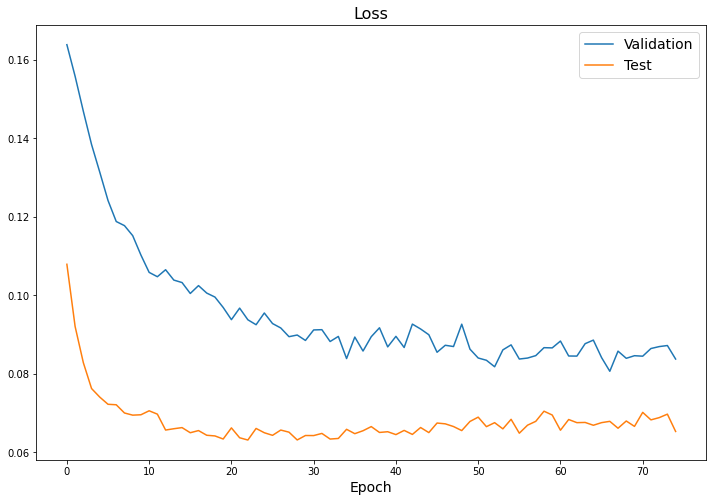

In [18]:
plt.figure(figsize=(12,8))
plt.plot(val_loss, label='Validation')
plt.plot(test_loss, label='Test')
plt.legend(fontsize=14)
plt.title('Loss', size=16)
plt.xlabel('Epoch', size=14)
plt.show()

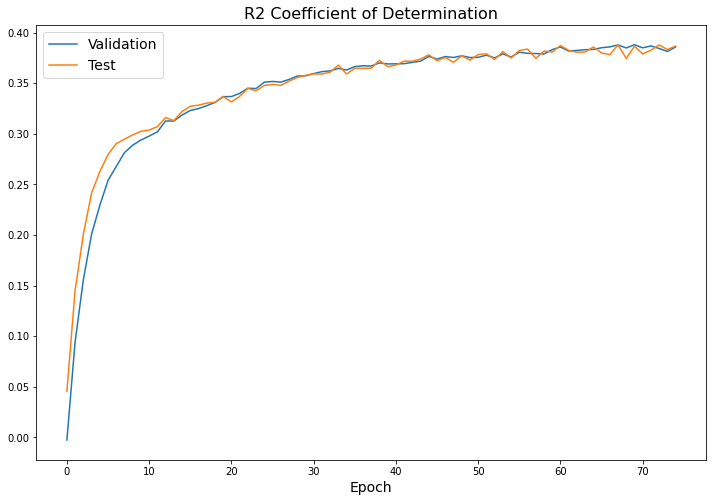

In [19]:
plt.figure(figsize=(12,8))
plt.plot(val_r2, label='Validation')
plt.plot(test_r2, label='Test')
plt.legend(fontsize=14)
plt.title('R2 Coefficient of Determination', size=16)
plt.xlabel('Epoch', size=14)
plt.show()

In [20]:
print('Best epoch:', best_epoch)

Best epoch: 69


In [21]:
set_random_seeds(seed_value=RANDOM_SEED, device=device)

mlp = MLP(6).to(device)
criterion = nn.MSELoss()
opt = torch.optim.Adam(mlp.parameters())

In [22]:
train_val_loader = DataLoader(TensorDataset(X[idx_train_val], y[idx_train_val]), batch_size=batch_size, shuffle=True)

In [23]:
for i in tqdm(range(best_epoch)):
    loss = epoch_train(mlp, train_val_loader, criterion, opt)

loss, r2 = epoch_val(mlp, test_loader, criterion)
print(f'Epoch: {best_epoch}, Test R2: {r2}')

100%|██████████| 69/69 [00:02<00:00, 28.73it/s]

Epoch: 69, Test R2: 0.3928638265594605


In [24]:
with torch.no_grad():
    pred_train_val = mlp(X[idx_train_val].to(device)).cpu()
    pred_test = mlp(X[idx_test].to(device)).cpu()

# Label Propagation

## GPyTorch CG

In [25]:
def label_propagation(adj, y_train, idx_train, idx_test, pred_train=None, pred_test=None):
    '''
    Attributes
    ----------
    adj: torch.sparse.FloatTensor
        normalized adjacency matrix
    '''
    L = torch.eye(len(adj)) - adj
    res_test = torch.zeros(len(idx_test), 1)
    if pred_train is None:
        res_train = y_train
    else:
        res_train = y_train - pred_train
    A = L[idx_test, :][:, idx_test]
    b = -L[idx_test, :][:, idx_train] @ res_train
    res_test = linear_cg(A, b)
    if pred_test is None:
        z = res_test
    else:
        z = pred_test + res_test
    return z

In [26]:
%timeit label_propagation(adj, y[idx_train_val], idx_train_val, idx_test)

10 loops, best of 5: 37.9 ms per loop


In [27]:
z = label_propagation(adj, y[idx_train_val], idx_train_val, idx_test)

In [28]:
r2_score(z, y[idx_test])

0.41428293947116124

## SciPy CG

In [29]:
def label_propagation_scipy(adj, y_train, idx_train, idx_test, pred_train=None, pred_test=None):
    '''
    Attributes
    ----------
    adj: scipy.sparse
        normalized adjacency matrix
    '''
    L = scipy.sparse.eye(adj.shape[0]) - adj
    z = np.zeros((len(idx_test), 1))
    if pred_train is None:
        res_train = y_train
    else:
        res_train = y_train - pred_train
    A = L[idx_test, :][:, idx_test]
    b = -L[idx_test, :][:, idx_train] @ res_train
    res_test = cg(A, b)[0].reshape(-1, 1)
    if pred_test is None:
        z = res_test
    else:
        z = pred_test + res_test
    return z

In [30]:
adj_sp = scipy.sparse.csr_matrix(adj.to_dense())

In [31]:
%timeit label_propagation_scipy(adj_sp, y[idx_train_val].numpy(), idx_train_val.numpy(), idx_test.numpy())

100 loops, best of 5: 2.44 ms per loop


In [32]:
z = label_propagation_scipy(adj_sp, y[idx_train_val].numpy(), idx_train_val.numpy(), idx_test.numpy())

In [33]:
r2_score(z, y[idx_test])

0.41428299093056464

# LP-MLP

In [34]:
z = label_propagation(adj, y[idx_train_val], idx_train_val, idx_test, pred_train_val, pred_test)

In [35]:
r2_score(z, y[idx_test])

0.5739378927667451

In [36]:
z = label_propagation_scipy(adj_sp, y[idx_train_val], idx_train_val, idx_test, pred_train_val, pred_test)

In [37]:
r2_score(z, y[idx_test])

0.5739368892201929